<a href="https://colab.research.google.com/github/chanhyeong00/machine_learning_study/blob/main/9.%20%EC%8B%9C%ED%80%80%EC%8A%A4%EC%99%80%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

시계열 데이터는 시간 간격을 두고 있는 일련의 데이터이다.
이 데이터를 그래프로 그릴 경우, 일반적으로 x축은 시간이 된다. ***무어의 법칙으로 예측한 값을 그래프로.***

시간축에 대해 여러 개의 값이 있는 경우를 **다변량 시계열** 이라고 부른다.

시간에 따른 강우량 같이 하나의 값만 존재한다면 이를 **일변량 시계열**이라고 부른다.

무어의 법칙은 50년 동안 유지된 규칙을 따르며, 미래를 대략적으로 예측하는 고정되고 간단한 규칙이므로 예측이 단순하다.



### 9.1. 시계열의 공통 특징 - 자세한 내용은 책으로



시계열은 랜덤하고 잡음이 많은 것처럼 보이지만 종종 예측 가능한 공통된 특징이 있다.

- 트렌드: 무어의 법칙에서는 시간에 따라 y축 값이 증가하는 상승 트렌드 관측. 시계열은 거의 일정하게 유지될 수도 있고, 하강트렌드가 있을 수 있다.

- 계절성: 많은 시계열이 시간에 따라 반복되는 패턴을 가진다. 반복은 **계절이라 부르는 일정한 간격**으로 일어난다. 계절에 따른 특정 패턴을 **계절성**이라고 한다.

- 자기상관: 어떤 이벤트 후에 예측 가능한 행동이 나타나는 것을 자기상관이라고 한다. 자기상관은 시계열 패턴에 감춰져 있을 수 있지만 예측 가능한 특징이므로 이를 포함한 시계열도 예측할 수 있다.

- 잡음: 시계열에 있는 랜덤한 변동이다. 이러한 변동은 예측을 어렵게 만들고 트렌드, 계절성, 자기상관을 가려버리기도 한다.

### 9.2. 시계열 예측 기법
머신러닝 기반 시계열 예측 전에 단순한 예측 방법을 보겠다. 이를 통해 머신러닝 예측의 정확도를 비교할 수 있는 **기준성능** 을 만들겠다.

#### 9.2.1. 기준 성능을 위한 단순한 예측


시계열을 예측하는 가장 기본적인 방법은 t+1 시간의 값을 t 시간의 값으로 예측하는 것이다.

이는 한 스텝만큼 시계열을 이동하는 효과를 낸다.

먼저 트렌드, 계절성, 잡음을 가진 시계열 데이터를 만들어보겠다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [3]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

# season_time이 0.4보다 작을 때는 코사인 함수로 계절성 패턴을 정의하고
# 그렇지 않을 때는 지수 함수로 정의
# where은 첫번째 매개변수가 참(true)이면 두번쨰 값을, 거짓이면 세번째 값으로
def seasonal_pattern(season_time):
  # 임의로 지정한 패턴이다
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  # 일정 간격마다 동일 패턴 반복
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 0
series = trend(time, .05)
amplitude = 15
slope = 0.09
noise_level = 6

# 시계열 만들기
series = baseline + trend(time, slope)\
                  + seasonality(time, period=365, amplitude=amplitude)
# 잡음 추가
series += noise(time, noise_level, seed=42)

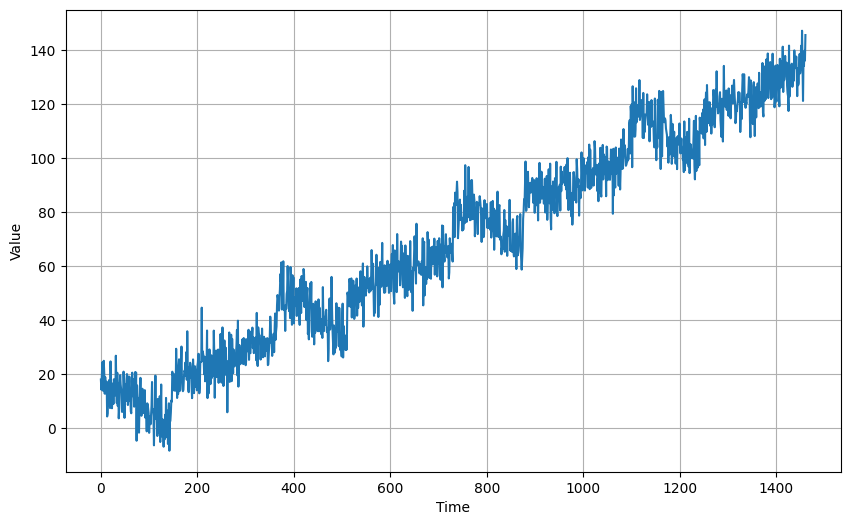

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

데이터가 준비되었으니 훈련 세트와 검증 세트, 테스트 세트로 나눈다.

데이터에 계절성이 관찰되므로 데이터를 나눌 때 각 분할에 계절성이 모두 포함되는 것이 좋다.

예를 들어 위의 그래프에선 스텝 1,000까지는 훈련세트, 이후는 검증세트로(왜지?)

스텝 t의 값을 단순히 스텝 t-1 의 값으로 예측하므로 이렇게 나눌 필요는 없다.

하지만 이어지는 그래프에서 타임스텝 1,000 이후의 데이터를 크게 확대하기 위해서 이 지점에서 나누었다.

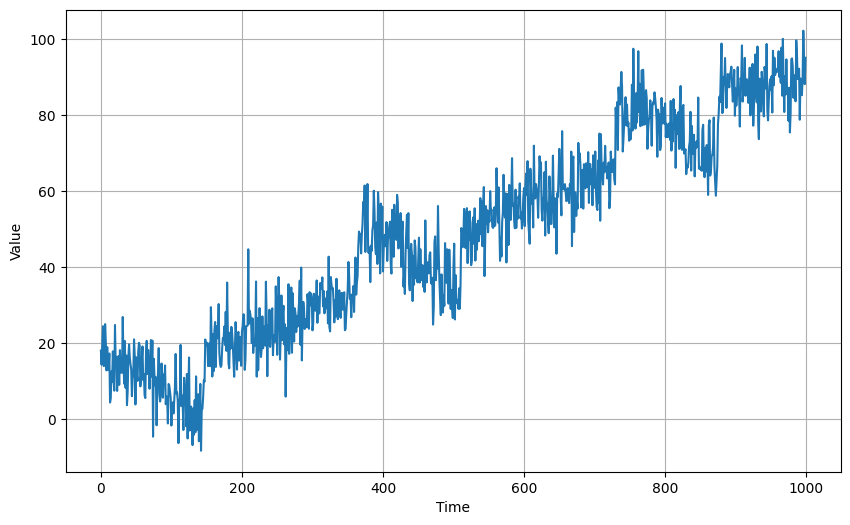

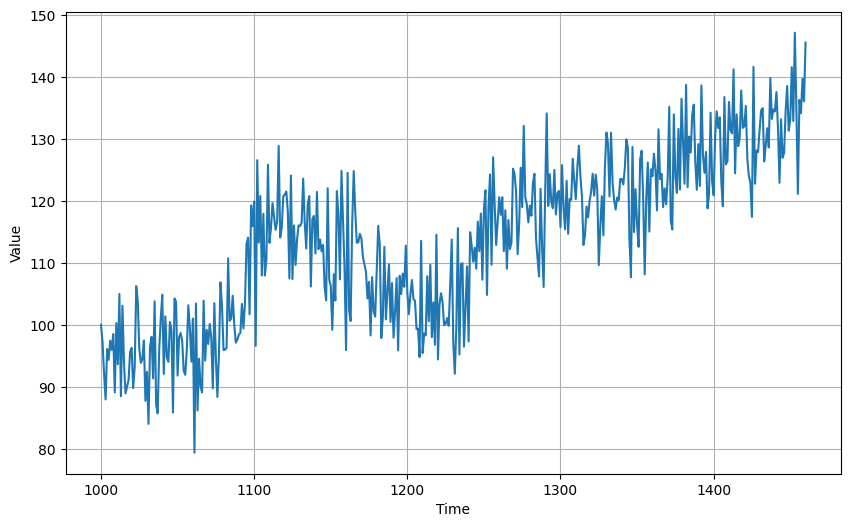

In [7]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

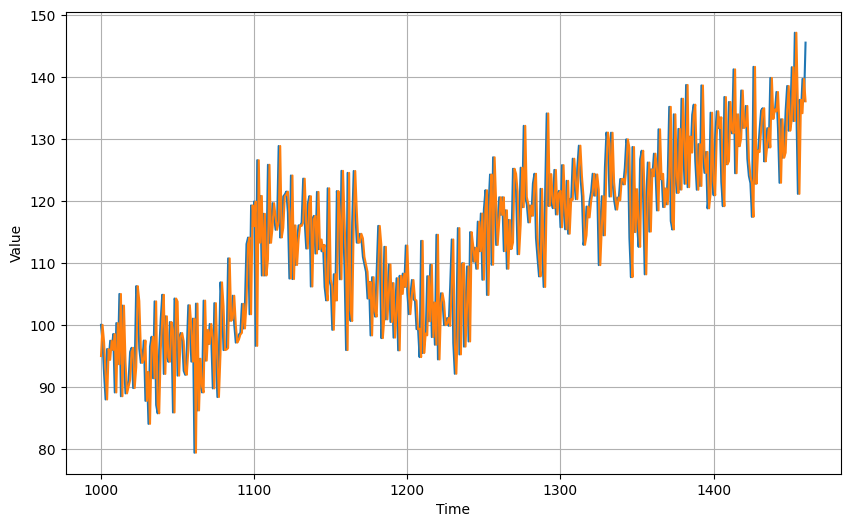

In [6]:
# 예측값

naive_forecast = series[split_time - 1:-1] # 단순하게 이전 값을 사용해서 예측(이동평균)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

그래프가 꽤 괜찮다. 두 그래프 값 사이에 관련성이 보이고 예측이 원래의 예측값과 가까워 보인다.

하지만 정확도를 어떻게 측정할까?

#### 9.2.2. 예측 정확도 측정하기

예측 정확도를 측정하는 방법은 많다. 그러나 여기선 평균 제곱 오차(MSE)와 평균 절대 오차(MAE)를 사용하겠다.

In [9]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

76.47492
6.899298


MSE 결과는 76.47, MAE 결과는 6.89이다.

이 오차를 줄일 수 있는 예측이라면 정확도가 더 높을 것이다.

#### 9.2.3. 이동 평균으로 예측하기

앞의 단순한 예측은 시간 t-1 의 값을 시간 t의 예측으로 선택한다.

이동 평균도 비슷하지만 t-1 의 값 대신 여러 값을 평균하여 시간 t의 예측값으로 사용한다.

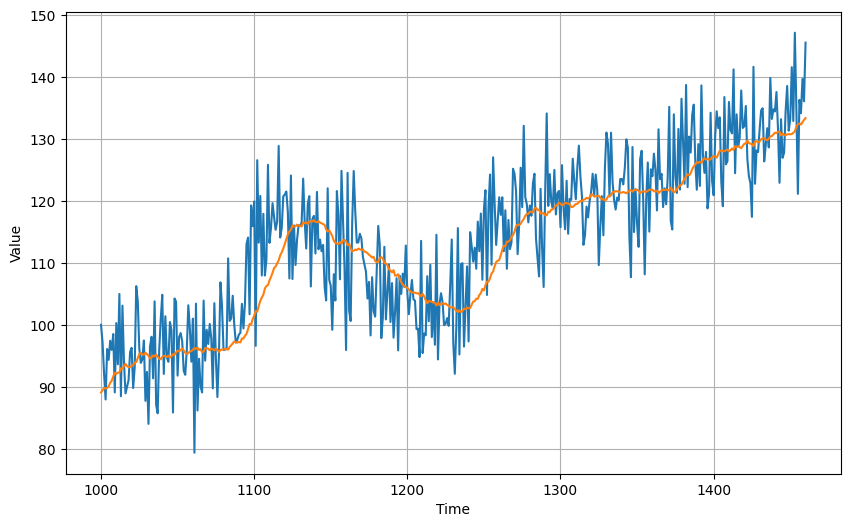

In [8]:
split_time = 1000
def moving_average_forecast(series, window_size):
  """ 마지막 몇 개 값의 평균을 사용하여 예측
    window_size=1이면 단순한 예측과 동일"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

moving_avg = moving_average_forecast(series, 30)[split_time-30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

원본 데이터와 이동 평균 결과이다.

In [11]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

49.044434
5.532835


MSE 결과는 49, MAE 결과는 5.5이다. 예측이 조금 향상되었다.

하지만 이 방식은 트렌드나 계절성을 고려하지 않으므로 약간의 분석을 통해 결과를 더 향상시킬 수 있다.

#### 9.2.4. 개선된 이동 평균 방법

이 시계열의 계절성은 365일이므로 시간 t의 값에서 t-365의 값을 빼서 트렌드와 계절성을 줄일 수 있다.

이렇게 하면 그래프가 평평해진다.

In [4]:
diff_series = (series[365:] - series[:-365])   # 시계열을 겹치지 않게 뺄셈해서 계절성을 없앤다.
time_diff = time[365:] # 시간은 총 3년

In [17]:
print(type(series))
print(series[365:], series[:-365])
print(diff_series)

<class 'numpy.ndarray'>
[ 45.44268   49.282333  48.09667  ... 139.7177   136.10208  145.56927 ] [ 17.980286  14.258191  19.057241 ...  99.440865 103.60882  113.065704]
[27.462395 35.024143 29.039427 ... 40.276833 32.493263 32.50357 ]


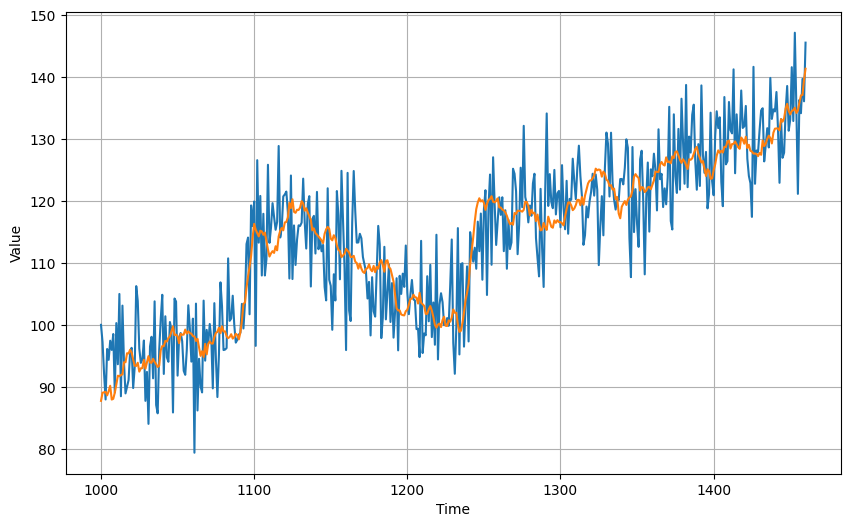

In [9]:
diff_moving_avg = \
    moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

diff_moving_avg_plus_smooth_past = \
    moving_average_forecast(series[split_time - 370:-360], 10) + \
    diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [11]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

40.902332
5.1360006


향상된 성능을 확인할 수 있다.